In [1]:
import sys
sys.path.insert(1, '../../scripts')

In [2]:
import os.path
from os import path

In [3]:
import random
import numpy as np
import pandas as pd
from scipy import stats
from itertools import groupby
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import parseaf as pa
import mdtraj as md
import alignment_quality as aq
import crutil

In [4]:
from Bio import SeqIO
from Bio import AlignIO
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

In [5]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
states = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

## Functions

In [8]:
def get_aa_freq(seq, aa):
    cnt = 0
    for i in seq:
        if i == aa:
            cnt += 1
    aa_freq = cnt / len(seq)
    return aa_freq

In [9]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

## Training logistic regression model using AlphaFold data

In [10]:
df = pd.read_csv('./data/sc-all-helical-and-disordered-regions.csv')

In [11]:
for aa in states:
    df['freq_'+aa] = df.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [12]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X = df[featurecol]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

## Conservation of labels in highly charged regions

In [13]:
df_hc = pd.read_csv('./data/charged-regions-with-structure-labels-low-thresh.csv')

In [14]:
fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
wrong_seq = []
for index, row in df_hc.iterrows():
    orf = row['orf']
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    contains_seq = False
    for record in msa:
        seq = crutil.remove_gaps(record.seq)
        if row['region.seq'] in seq:
            contains_seq = True
    if not contains_seq:
        wrong_seq.append(index)

In [15]:
df_hc.drop(df_hc.index[wrong_seq], inplace=True)

In [16]:
def append_percent_aa(row, aa):
    seq = row['seq']
    return get_aa_freq(seq, aa)

In [17]:
def append_structure_conservation(row):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    orf = row['orf']  
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    sc_label = row['label']
    
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    if len(msa) >= 15:
        region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
        tmpdf = pd.DataFrame(columns=['seq', 'is_sc'])
        for seq in region_msa:
            s = crutil.remove_gaps(seq.seq)
            name = seq.id
            if len(s) >= 25 and name != 'Saccharomyces':
                tmpdf = tmpdf.append({'seq': s, 'is_sc': 0}, ignore_index=True)
            elif refseq in s and name == 'Saccharomyces':
                tmpdf = tmpdf.append({'seq': refseq, 'is_sc': 1}, ignore_index=True)
        if len(tmpdf) >= 15 and len(tmpdf[tmpdf.is_sc == 1]) >= 1:
            for aa in states:
                tmpdf['freq_'+aa] = tmpdf.apply(lambda r: append_percent_aa(r, aa), axis=1)
            featurecol = []
            for aa in states:
                featurecol.append('freq_'+aa)
            X = tmpdf[tmpdf.is_sc == 0][featurecol]
            y = logreg.predict(X).tolist()
            sc_X = tmpdf[tmpdf.is_sc == 1][featurecol]
            sc_y = logreg.predict(sc_X).tolist()[0]
            if sc_y == sc_label:
                return y.count(sc_label) / len(y)
            else:
                return -y.count(sc_label) / len(y)
        elif len(tmpdf[tmpdf.is_sc == 1]) == 0:
            print(orf)
    else:
        return None

In [18]:
df_hc['cons'] = df_hc.apply(lambda row: append_structure_conservation(row), axis=1)

## Conservation of secondary structure in randomly selected regions

In [19]:
df_random = pd.read_csv('./data/random-non-highly-charged-regions-from-AF-low-thresh.csv')

In [20]:
with open('../../../alignment-free/data/yeast.txt') as f:
    mappings = {}
    for line in f:
        uniprot = line[95:106].rstrip()
        orf = line[75:95].rstrip()
        mappings[uniprot] = orf

In [22]:
fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
bad_seq = []
for index, row in df_random.iterrows():
    orf = mappings[row['uni_id']]
    try:
        msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
        contains_seq = False
        for record in msa:
            seq = crutil.remove_gaps(record.seq)
            if row['seq'] in seq:
                contains_seq = True
        if not contains_seq:
            bad_seq.append(index)
    except:
        bad_seq.append(index)

In [23]:
df_random.drop(df_random.index[bad_seq], inplace=True)

In [24]:
def append_structure_conservation2(row):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    orf = mappings[row['uni_id']]
    refseq = row['seq']
    left_bound = row['left_bound']
    right_bound = row['right_bound']
    sc_label = row['label']
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    if len(msa) >= 15:
        region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
        tmpdf = pd.DataFrame(columns=['seq', 'is_sc'])
        for seq in region_msa:
            s = crutil.remove_gaps(seq.seq)
            name = seq.id
            if len(s) >= 25 and name != 'Saccharomyces':
                tmpdf = tmpdf.append({'seq': s, 'is_sc': 0}, ignore_index=True)
            elif refseq in s and name == 'Saccharomyces':
                tmpdf = tmpdf.append({'seq': refseq, 'is_sc': 1}, ignore_index=True)
        if len(tmpdf) >= 15 and len(tmpdf[tmpdf.is_sc == 1]) >= 1:
            for aa in states:
                tmpdf['freq_'+aa] = tmpdf.apply(lambda r: append_percent_aa(r, aa), axis=1)
            featurecol = []
            for aa in states:
                featurecol.append('freq_'+aa)
            X = tmpdf[tmpdf.is_sc == 0][featurecol]
            y = logreg.predict(X).tolist()
            sc_X = tmpdf[tmpdf.is_sc == 1][featurecol]
            sc_y = logreg.predict(sc_X).tolist()[0]
            if sc_y == sc_label:
                return y.count(sc_label) / len(y)
            else:

                return -y.count(sc_label) / len(y)
    else:
        return None

In [25]:
df_random['cons'] = df_random.apply(lambda row: append_structure_conservation2(row), axis=1)

## Summary plot

In [26]:
df_hc['abs_cons'] = df_hc['cons'].abs()
df_random['abs_cons'] = df_random['cons'].abs()

In [27]:
df_hc_matched = df_hc[df_hc.cons >= 0]
df_random_matched = df_random[df_random.cons >= 0]

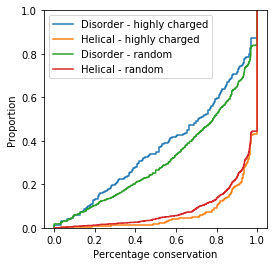

In [28]:
plt.figure(figsize=(4,4))
bw = 0.5
sns.ecdfplot(data=df_hc[df_hc.label == 'helix'], x='abs_cons')
sns.ecdfplot(data=df_hc[df_hc.label == 'disordered'], x='abs_cons')
sns.ecdfplot(data=df_random[df_random.label == 'helix'], x='abs_cons')
sns.ecdfplot(data=df_random[df_random.label == 'disordered'], x='abs_cons')
plt.legend(['Disorder - highly charged', 'Helical - highly charged',
            'Disorder - random', 'Helical - random'])
plt.xlabel('Percentage conservation')
plt.show()

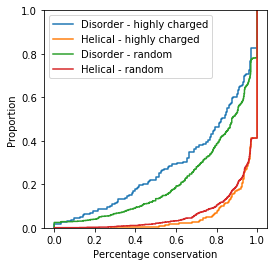

In [29]:
plt.figure(figsize=(4,4))
bw = 0.5
sns.ecdfplot(data=df_hc_matched[df_hc_matched.label == 'helix'], x='cons')
sns.ecdfplot(data=df_hc_matched[df_hc_matched.label == 'disordered'], x='cons')
sns.ecdfplot(data=df_random_matched[df_random_matched.label == 'helix'], x='cons')
sns.ecdfplot(data=df_random_matched[df_random_matched.label == 'disordered'], x='cons')
plt.legend(['Disorder - highly charged', 'Helical - highly charged',
            'Disorder - random', 'Helical - random'])
plt.xlabel('Percentage conservation')
plt.show()

In [ ]:
YER177W

## Spot checking outliers

In [26]:
def prediction_viewer(orf, left_bound):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    row = df_hc[(df_hc.orf == orf) & (df_hc['left.bound'] == left_bound)].iloc[0]
    orf = row['orf']  
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    sc_label = row['label']

    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)

    tmpdf = pd.DataFrame(columns=['seq'])
    for seq in region_msa:
        s = crutil.remove_gaps(seq.seq)
        if len(s) >= 25:
            tmpdf = tmpdf.append({'seq': s}, ignore_index=True)

    for aa in states:
        tmpdf['freq_'+aa] = tmpdf.apply(lambda r: append_percent_aa(r, aa), axis=1)
    featurecol = []
    for aa in states:
        featurecol.append('freq_'+aa)
    X = tmpdf[featurecol]
    y = logreg.predict(X).tolist()
    for index,row in tmpdf.iterrows():
        print(row['seq'], y[index])
        

In [27]:
df_hc[(df_hc.label == 'disordered') & (df_hc.cons < 0.8)].sort_values(by='cons')

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,label,cons
131,YER164W,CHD1,1469,911,964,LGGEEFLKQFEVTDYKADIDWDDIIPEEELKKLQDEEQKRKDEEYV...,54,0.082990,0.500000,0.063532,0.164148,P32657,disordered,0.030303
476,YOR326W,MYO2,1575,1016,1058,TEQTLKDAQLELEDMVKQHDELKEESKKQLEELEQTKKTLVEY,43,0.041860,0.465116,0.064220,0.171847,P19524,disordered,0.088235
56,YDL058W,USO1,1791,1074,1140,NKISELTKTREELEAELAAYKNLKNELETKLETSEKALKEVKENEE...,67,0.012037,0.462687,0.038101,0.090771,P25386,disordered,0.526316
24,YBR081C,SPT7,1333,306,364,IYHSFEYDKETMIKRLKLEESDKMIEKGKKKRSRSDLEAATDEQDR...,59,0.005260,0.491525,0.128023,0.282015,P35177,disordered,0.531250
283,YKL195W,MIA40,404,69,124,PLFASRKVESDKTAEEELSSGGEQSPENEDDNNSKSDENGDDNDSK...,56,0.131211,0.410714,0.072573,0.266881,P36046,disordered,0.571429
126,YER036C,ARB1,611,2,58,PVSASKAKRDAKKAEREAKKAAAGKTIRKLGRKKEAAAEESEVDAA...,57,0.043185,0.456140,0.089035,0.235717,P40024,disordered,0.593750
405,YNL102W,POL1,1469,0,57,MSSKSEKLEKLRKLQAARNGTSIDDYEGDESDGDRIYDEIDEKEYR...,58,0.014863,0.500000,0.130725,0.288834,P13382,disordered,0.677419
11,YAR003W,SWD1,427,348,405,SALAPDFEEVEENVDYLEKEDEFDEVDEAEQQQGLEQEEEIAIDLR...,58,0.214854,0.448276,0.084773,0.322094,P39706,disordered,0.727273
433,YNL286W,CUS2,286,135,187,DNMHGKENDLKEFNGPEPPIKRLKKAKSEGEGEVIDYNDDESLAKA...,53,0.013722,0.415094,0.113279,0.321812,P53830,disordered,0.730769
335,YLR277C,YSH1,780,482,536,NIVNEIYKEENVEIKEEIAAKIEPIKEENEDNLDSQAEKGLVDEEE...,55,0.109091,0.436364,0.057312,0.186142,Q06224,disordered,0.750000


In [28]:
prediction_viewer('YDL058W', 1074)

TSAASFNRAHGLPPAEAIEPVVEVDERNPGPRAGVPPPPKALGGARPLV disordered
AEVSDLKKTIETLQSELDSSNEQNATEVS disordered
SDLASSEKDLASKTKDVSAKDTEIEKLKSELETANSKLASTAKEVEILTSELKAAKSDACDSETKIKAVESELVEQKSKVEHLNAELA disordered
EKVESIEKALESEKSSNKSLSEEKKLAEEKLEKLGNDLQQHQSSHESVVQEKTALTKKIE helix
DPSQEHKNVLVLSASSTVPPDQQIEEEISNGKEPDSQAVVRELEEKLAQTTKHLL disordered
SQKKKLENELSSLKQKHSDFSNQSETLTRELSDLKSSHEQLLGEKIIHDSAKAELDSQIASLNAKIAEFEASQAADKKDSD disordered
EEKRALENEKSELQKRWEEEKQKLEQEKDAQIKEYE helix
DENKTLKQQVEKIKDSSASAENQKSAVLSEFAQLREEKENKIS disordered
AANLELRNQIQNMQKKYDETVAKYKEEIENLKRQHTVEIELLKNNLNISEGQQSELESKLGKANEEIVKLAKTVEEKSACFK helix
EEKTGLEGQIASLSTEVAKLTEDMEVSSKAVKYELEELKKENERLKAELDASSELVAAKGEELNQNEQ helix
SRVQELREEISVLRSNLQDSEETHKLEISAYTDELDILKTDHSSVLAEYEHLKELYEKAVEGRSSQEADPSVSSNKEQIAKIIEDKETELKTSSKRVK disordered
EEKNKLKKQVEELEAKISSLKEDHESKSLSGVQEKESLTKELQVAKEQLKKLQKEVSTKESQVLEKSKELEEATKLSDSKAT helix
CENEKLKKDLEDIDNSKENAEAKQKSVEEELSNFKTKHSKVREELEKSLDAKTGEYNDAIEKLKNKDISIASLKETHSKKVS disordered
TKNKNLQEKLDSTVST

In [29]:
prediction_viewer('YER164W', 911)

LGGEEFLNQFAVQDVKADMTSWEDIIPADDRERALAKLEEEAKEAKAKAQADSTR helix
LGGEEFLKQFEVTDFKADVTWDDIIPEDDRKRIKEEEDERRNDEYLQQQMAASS disordered
MGGEEFLKQFEVTDYKADVSWDDIIPLTEREKFEEEDRLREEEEALKQEIELSS helix
MGGEEFLKQFEVTDYKAEDLNWDDIIPEEEMERIEEEERMLAAQRAKEEERERRE helix
SGGIDWDNWMQVTDVKVDDLALDWDQIIPAEQLAAIKAEENRKKEEEYLAKTIEENA helix
SGGIDWDNFMQITDVKVDDINLDWDQIIPAEKLAEIKAEEEKKQHEDYLAQVAAESA helix
DGGEEFLRAFEYVDIKVDDLSWDDIIPKEQLEEIKAEEKKKADERYLAEVIEQNR helix
LGGEEFLKQFEVTDYKADVSWDDIIPASELQRIKEEEQKRKNDEFLQEQIKMNS helix
LGGEEFLKQFEVTDYKADVDWDDIIPANELAKIKADDLRRKDEEYVKEQMDLMN helix
LGGEEFLKQFEVTDYKADMTWDDIIPADELAKIKEEEQKRKDDEYLQEQIAMFA helix
LGGEEFLKQFEVTDYKADVSWDDIIPPEELARLKDEEKKRRDELYLQEQIQMSS helix
LGGEEFLRQFEVTDYKANVEWDDIIPEEELQKIKEEEKKRKDEIFLQEQIEMSS helix
LGGEEFLKQFEVTDYKADVDWDDIIPEDELKKLKEEEKKREDDAYLQQQIQMYS helix
LGGEEFLKQFEVTDYKADVDWDDIIPEDELKKLKEEEKKRQDEEYLKEQIEMFS helix
LGGEEFLKQFEVTDYKADVDWDDIIPEEELKKLKEDEKKRQDEQYLQQQIEMYS helix
LGGEEFLRQFEVTDYKADVDWDDIIPEEDLKRIKEEEEKRKEETFLQEQIEMSS helix
LGGEEFLKQF

In [30]:
prediction_viewer('YGR285C', 228)

SWRSFEYADKDVAEGADSRDEKRHQEKKNKAERDRKKKEDNTRRRTLVDQGLALDPRIKQFRAAEKAAREAKRRGGAGVPAQLDPAEKAEQEKKAKELAEAEAAAAAAKEAADKADREVQKKAKAAAAKEVKKNKKAISNAVS disordered
SWRTFEYLDKDIPDDSDNRDQKRYQEKKNKADRAKRKTEDTARLRKLVDDVLAQDPRIKMFKQAEKEAKEKAKWERERGAREAAEAAKRAEEEEAARKQKEEDEAKLAAVDKKAQKEKAKKESKKNKKTIKNALK disordered
SWRSFEYLDKDIPDDGESRDNKRFQEKKNRSERQKNKARDNARLRNLVDTALASDPRIKLFKEQEKAAKAARKWEREAGAREAAAAAQKKKEEEERRAAEEAAAKASAAAANKKAKEDKKKAQKRDKKVVKNALK disordered
SWRSFEYLDEDVPDDSESRDQRRHTERKNLNTRKKRKAEDNARLRKLLDDCSAADERIKKFRQEANAAKNKKRLEKEAAEKKAAEEAAAKKAAEEAAAKEAEEKAKADREASKKAKEAAKNAVKKNKRVLRGSVK disordered
SWRSFEYLDEDVPDDGESRDHKRHVERKNANSRKKKKAEDNARLRKLLDDASAGDERIKRFRQEANAAKNKKKLEKEAAEKKAAEEAQAKKEAEEKAKAEAEAAAKADREAGKKAKEAAKNALKKNKRVLKGSVK disordered
SWRTFEYLDEDVPDDNENRDQKRHMEKKNANARRKRKTEDTTRLRHLVDDCAAGDERIKKFRKAARADKDRKRLEKEAEIKRLAEEKEKARLEEEQRKKDAEEAAKAEREQNKKAKEAAKNAAKKNKRVLKGSVK disordered
SWRSFEYLDEDVPDDSDNRDNKRHTERKNKTARQKRKTEDTARLRKSVDDCLTSDPRVKVFKEAERMAKEQRKWEREADARKASEQAKKAKEEEERRRKEEEERSKEERS

## Conservation vs. abundance

In [31]:
df_abundance = pd.read_table('./data/4932-Yeast_GeneName_Intensity_Breker_2103.txt', comment='#')

In [32]:
abundance_dict = {}
for index,row in df_abundance.iterrows():
    orf = row['string_external_id'].split('.')[1]
    abundance = row['abundance']
    abundance_dict[orf] = abundance

In [33]:
df_hc['abundance'] = df_hc['orf'].map(abundance_dict)

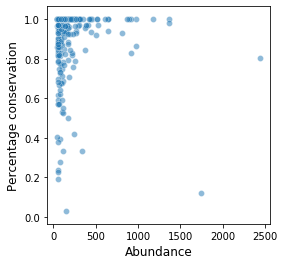

In [34]:
plt.figure(figsize=(4,4))
sns.scatterplot(data=df_hc, x='abundance', y='cons',
                alpha=0.5)
plt.xlabel('Abundance', fontsize=12)
plt.ylabel('Percentage conservation', fontsize=12)
plt.show()

In [35]:
df_hc[(df_hc.abundance > 1500) & (df_hc.cons <= 0.2)]

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,label,cons,abundance
196,YGR285C,ZUO1,434,228,362,SWRTFEFLDEDVPDDSSNRDHKRYIERKNKAARDKKKTADNARLVK...,135,0.023474,0.525926,0.072776,0.148288,P32527,helix,0.121212,1743.0
